In [1]:
%matplotlib notebook

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

In [4]:
# If not pip installing add import path
print(os.getcwd())
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

/Users/jrobinson/nice_orbs/tutorials


In [5]:
from nice_orbs.orb_class import BodyOrb
import nice_orbs.orb_funcs as orb_funcs

In [6]:
# define orbital parameters for body 1 and 2

orb_dict1 = {"a":2,
            "e":0.3,
            "inc":np.radians(30),
            "peri":np.radians(30),
            "node":np.radians(60),
            "M":np.radians(120)
           }
orb_dict2 = {"a":1,
            "e":0.3,
            "inc":np.radians(120),
            "peri":np.radians(175),
            "node":np.radians(45),
            "M":np.radians(90)
           }

In [7]:
# define the primary orbit
bod1 = BodyOrb()
bod1.load_dict(orb_dict1)
bod1.print_orb()

a=2,e=0.3,inc=0.5235987755982988,peri=0.5235987755982988,node=1.0471975511965976,f=None


In [8]:
# calculate the required values and vectors for the primary orbit
bod1.calc_orb_vectors()
bod1.calc_values()
bod1.print_orb()

a=2,e=0.3,inc=0.5235987755982988,peri=0.5235987755982988,node=1.0471975511965976,f=2.51895611193094


In [9]:
# define the 2nd orbit and calulate values & vectors
bod2 = BodyOrb()
bod2.load_dict(orb_dict2)
bod2.calc_orb_vectors()
bod2.calc_values()
bod2.print_orb()

a=1,e=0.3,inc=2.0943951023931953,peri=3.0543261909900767,node=0.7853981633974483,f=2.138780472453006


In [10]:
# define range of f_true to plot orbit positions
f_true = np.linspace(0,2*np.pi,100)
f_true = f_true.reshape((len(f_true),1))
f_true.shape

(100, 1)

In [11]:
# define a surface in the xy plane
xx, yy = np.meshgrid(np.linspace(-3,3,2), np.linspace(-3,3,2))
zz = np.zeros(xx.shape)

In [12]:
# define the transform from cartesian (x, y, z) ref frame to bod1 ref frame (_x, _y, _z)
# In the _x_y_z frame the _x axis is aligned with the bod1 ascending node (this is not the bod1:bod2 mutual ascending node!)
# i.e. rotate xyz by bod1.node around z
# _x_y_z is coplanar to the bod1 orbital plane
# i.e. then rotate by bod1.inc around _x
trans_bod1 = orb_funcs.rot_matrix(alpha = bod1.inc, gamma = bod1.node)
trans_bod1

array([[ 0.5      , -0.75     ,  0.4330127],
       [ 0.8660254,  0.4330127, -0.25     ],
       [ 0.       ,  0.5      ,  0.8660254]])

In [13]:
# inverse of trans_bod1: transform from bod1 ref frame to cart ref frame
# note that we change the sign of the angles and the order of operation around the xyz axes
_trans_bod1 = orb_funcs.rot_matrix(alpha = -bod1.inc, gamma = -bod1.node, order = [2,1,0])
_trans_bod1

array([[ 0.5      ,  0.8660254,  0.       ],
       [-0.75     ,  0.4330127,  0.5      ],
       [ 0.4330127, -0.25     ,  0.8660254]])

In [14]:
# get the unit vectors in both reference frames
x_vec = np.array([1,0,0]).T
y_vec = np.array([0,1,0]).T
z_vec = np.array([0,0,1]).T
unit_vec = np.array([x_vec,y_vec,z_vec])
print(unit_vec,unit_vec.shape)
_unit_vec = np.dot(trans_bod1,unit_vec).T
print(_unit_vec,_unit_vec.shape)

[[1 0 0]
 [0 1 0]
 [0 0 1]] (3, 3)
[[ 0.5        0.8660254  0.       ]
 [-0.75       0.4330127  0.5      ]
 [ 0.4330127 -0.25       0.8660254]] (3, 3)


In [15]:
# get the x, y surface representation in the _x, _y frame

ref_plane = np.array([xx,yy,zz])

_xx = []
_yy = []
_zz = []
for i in range(ref_plane.shape[1]):
    for j in range(ref_plane.shape[2]):
        _vec = np.dot(trans_bod1, ref_plane[:,i,j])
        _xx.append(_vec[0])
        _yy.append(_vec[1])
        _zz.append(_vec[2])
        
_xx = np.array(_xx).reshape(xx.shape)
_yy = np.array(_yy).reshape(yy.shape)
_zz = np.array(_zz).reshape(zz.shape)

ascending nodal dist = 0.19283218200382474
descending nodal dist = 1.631902852827076


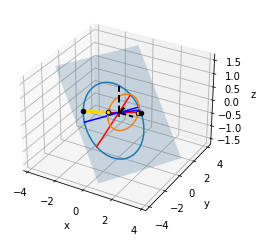

In [16]:
# calculate nodal distance in the bod1 frame
x_plot = "x"
y_plot = "y"
z_plot = "z"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0],projection='3d',computed_zorder=False)

# mark the origin
ax1.scatter(0,0,0, marker = "+", c = "k", s = 50)

# plot the _x, _y surface which is coplanar to bod1
c2 = ax1.plot_surface(_xx, _yy, _zz, 
                 label = "bod1 orbit frame",
                 alpha=0.2)
# modify plot parameters to get the legend
c2._facecolors2d=c2._facecolor3d
c2._edgecolors2d=c2._edgecolor3d

# plot the x, y, z frame unit vectors
for i,l in zip(range(unit_vec.shape[0]),["x","y","z"]):
    ax1.plot([0,unit_vec[i,0]],[0,unit_vec[i,1]],[0,unit_vec[i,2]],
            c = "k", label = l, ls = "--", zorder = 5, lw = 2)

# For each orbit:
for i,bod in enumerate([bod1, bod2]):

    # get the orbit positions and apsidal, nodal coordinates (in x, y, z frame)
    orb = np.array(bod.pos_vel_from_orbit(f_true)[[x_plot,y_plot,z_plot]])
    angle = 0
    aps_line = np.array(bod.pos_vel_from_orbit(np.array([angle,angle+np.pi]).reshape((2,1)))[[x_plot,y_plot,z_plot]])
    angle = - bod.peri
    node_line = np.array(bod.pos_vel_from_orbit(np.array([angle,angle + np.pi]).reshape((2,1)))[[x_plot,y_plot,z_plot]])

    # plot the orbit, apsides and nodes
    ax1.plot(orb[:,0],orb[:,1],orb[:,2], c = "C{}".format(i))
    ax1.plot(aps_line[:,0],aps_line[:,1],aps_line[:,2],
               c = "r",
            label = "apsidal line {}".format(i))
    ax1.plot(node_line[:,0],node_line[:,1],node_line[:,2],
               c = "b",
            label = "nodal line {}".format(i))
    
    # for bod2:
    if i>0:
        
        # use the function to find the true anomalies (in bod1/bod2 orbital elements) of the mutual ascending node between bod1 and bod2
        node_mutual_f1,node_mutual_f2 = orb_funcs.mutual_ascending_node_f_true(bod1,bod2) # nodes are for bod1 and bod2 respectively
        
        # loop through the ascending and descending (180 degrees away from ascending)
        for _f1,_f2,node_label in zip([node_mutual_f1,node_mutual_f1+np.pi],
                           [node_mutual_f2,node_mutual_f2+np.pi], 
                          ["ascending","descending"]):

            # find the vector position of the node for both orbits
            node1 = bod1.r_vec(_f1)
            node2 = bod2.r_vec(_f2)
            # find the distance between the nodal position vectors
            node_dist = np.linalg.norm(node2 - node1)
            print("{} nodal dist = {}".format(node_label,node_dist))
        

            ax1.plot([node1[0],node2[0]],[node1[1],node2[1]],[node1[2],node2[2]],
                 c = "gold", lw = 3)            
            ax1.scatter(node2[0],node2[1],node2[2],
                 edgecolor = "k", facecolor = "gold",
                        label = "bod2 {} node".format(node_label),
                       zorder = 5)
            ax1.scatter(node1[0],node1[1],node1[2],
                        label = "bod1 {} node".format(node_label),
                 c = "k", zorder = 5)
    
    
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.set_zlabel(z_plot)

# ax1.set_box_aspect((np.ptp(orb[:,0]), np.ptp(orb[:,1]), np.ptp(orb[:,2])))

# ax1.legend()

plt.show()